In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import read_excel
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from math import sqrt
plt.style.use('fivethirtyeight')

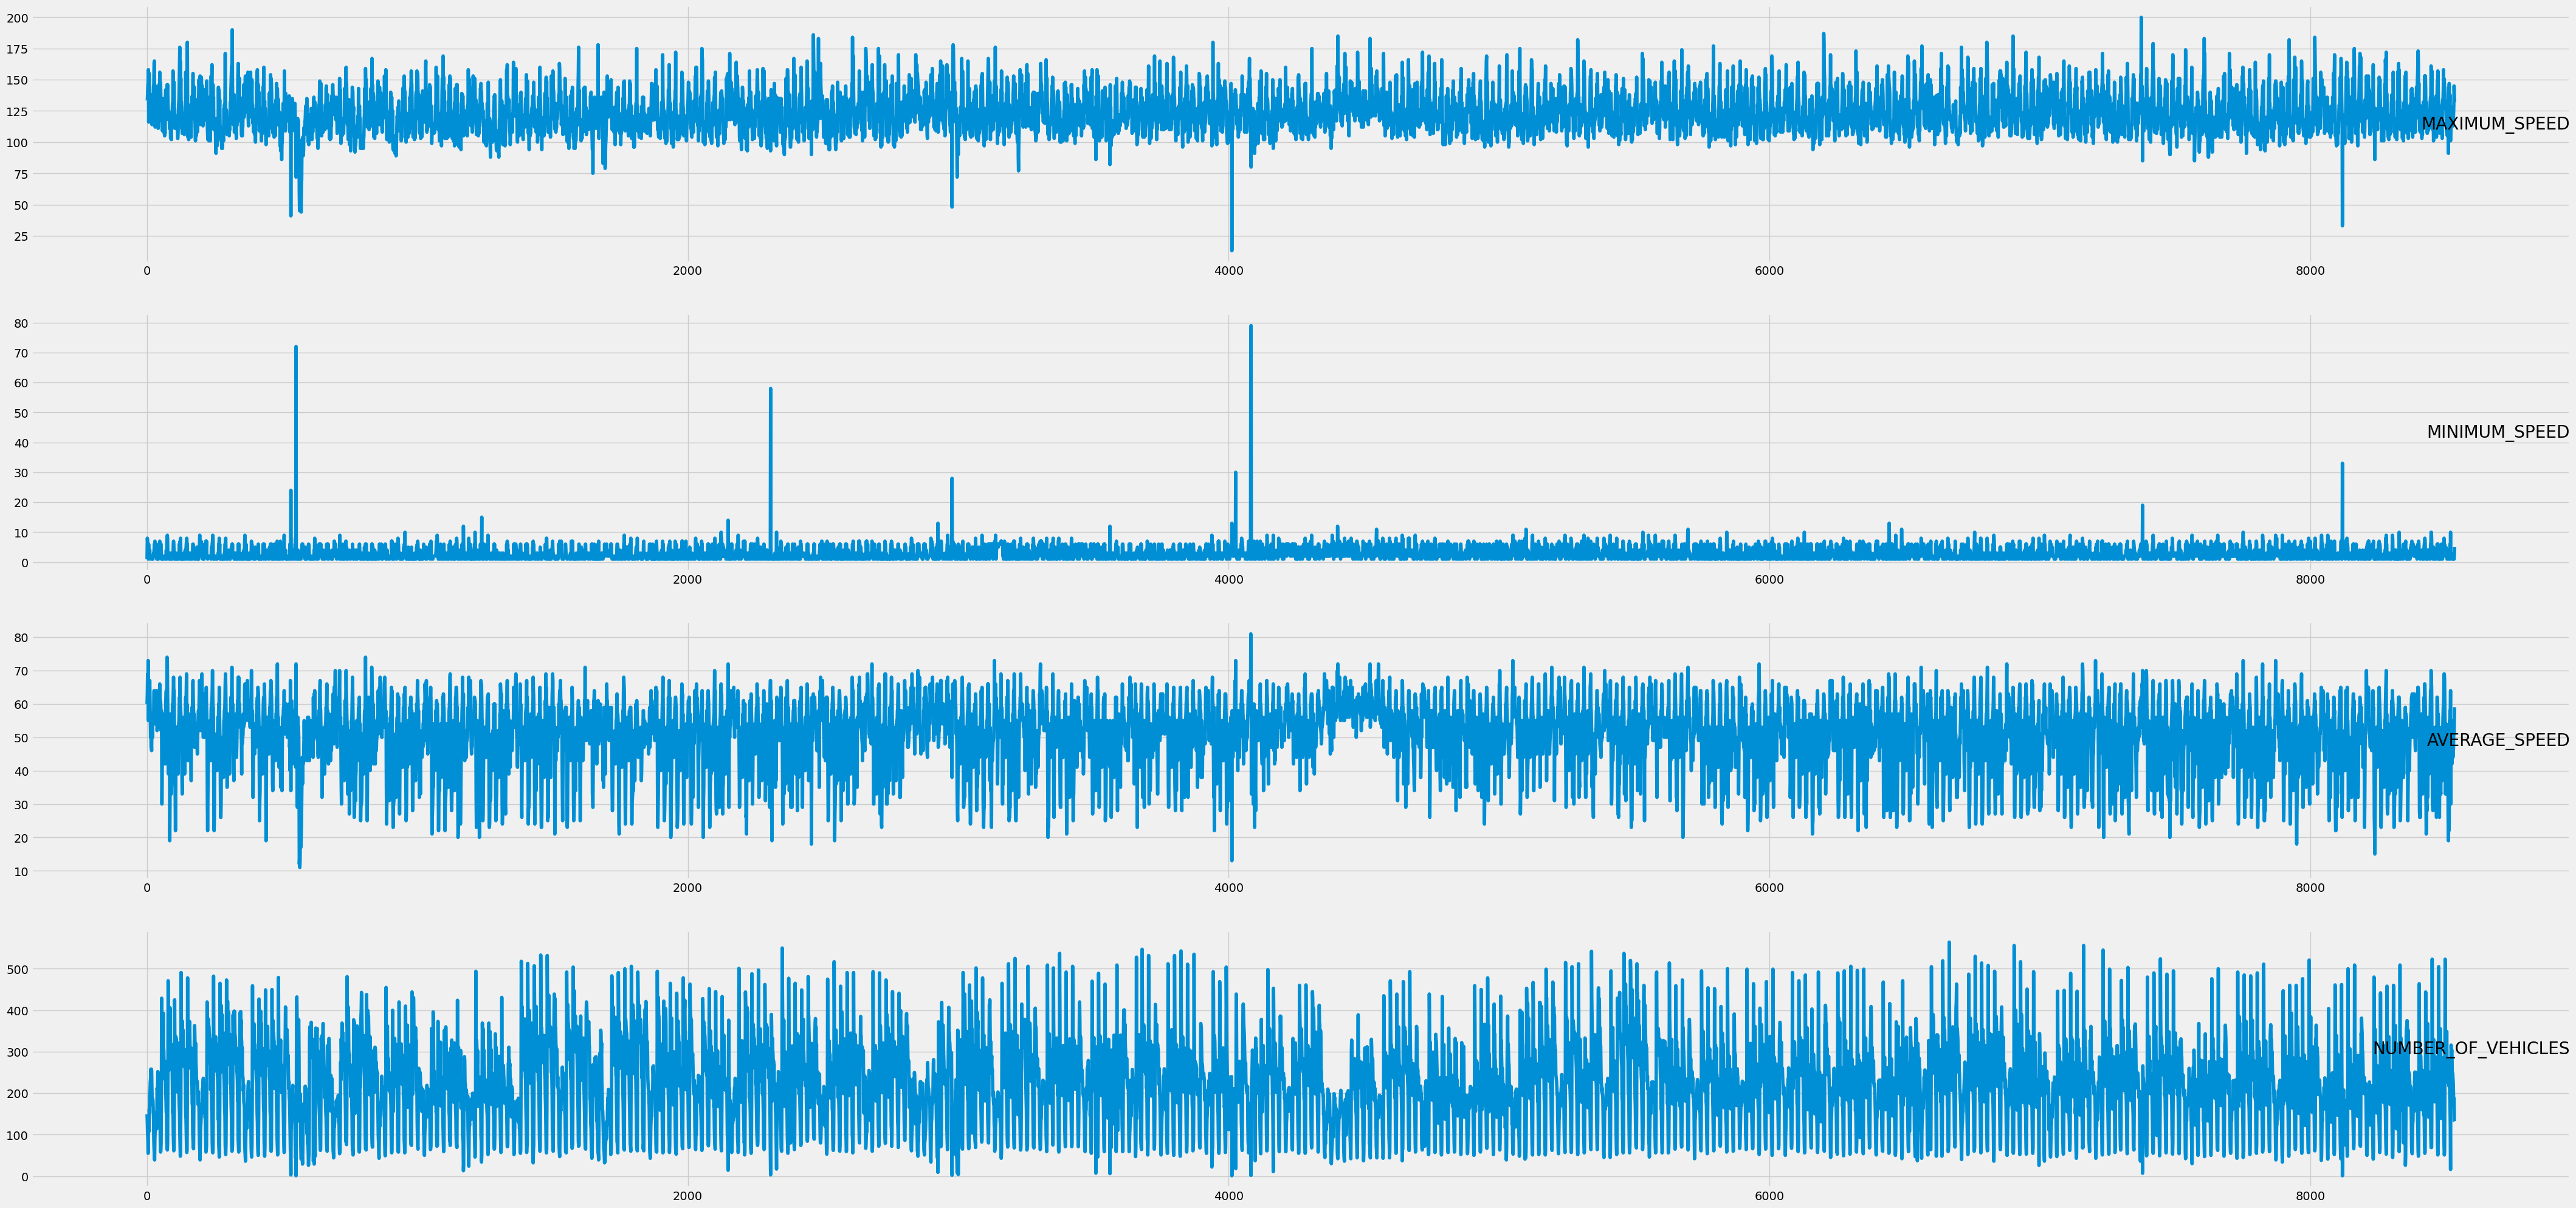

In [2]:
# load dataset
dataset = read_excel(r'C:\sxk990.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure(figsize=(48, 24))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [4]:
# specify the number of lag hours
n_hours = 6
n_steps = 3
n_features = 4
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var1(t-5)  var2(t-5)  \
6         133.0        1.0       60.0      149.0      133.0        8.0   
7         133.0        8.0       63.0      130.0      139.0        7.0   
8         139.0        7.0       69.0      101.0      145.0        3.0   
9         145.0        3.0       61.0       90.0      148.0        6.0   
10        148.0        6.0       73.0       55.0      158.0        1.0   
...         ...        ...        ...        ...        ...        ...   
8528      118.0        2.0       53.0      291.0      122.0        2.0   
8529      122.0        2.0       55.0      302.0      128.0        2.0   
8530      128.0        2.0       42.0      304.0      124.0        2.0   
8531      124.0        2.0       45.0      263.0      121.0        1.0   
8532      121.0        1.0       49.0      217.0      116.0        1.0   

      var3(t-5)  var4(t-5)  var1(t-4)  var2(t-4)  ...  var2(t-2)  var3(t-2)  \
6          63.0      130.0      139.0        7.0  ...        6.0       73.0   
7          69.0      101.0      145.0        3.0  ...        1.0       55.0   
8          61.0       90.0      148.0        6.0  ...        6.0       60.0   
9          73.0       55.0      158.0        1.0  ...        3.0       56.0   
10         55.0      105.0      116.0        6.0  ...        2.0       58.0   
...         ...        ...        ...        ...  ...        ...        ...   
8528       55.0      302.0      128.0        2.0  ...        1.0       49.0   
8529       42.0      304.0      124.0        2.0  ...        1.0       49.0   
8530       45.0      263.0      121.0        1.0  ...        2.0       44.0   
8531       49.0      217.0      116.0        1.0  ...        1.0       46.0   
8532       49.0      248.0      124.0        2.0  ...        1.0       47.0   

      var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var3(t)  \
6          55.0      158.0        1.0       55.0      105.0     60.0   
7         105.0      116.0        6.0       60.0      124.0     56.0   
8         124.0      124.0        3.0       56.0      107.0     58.0   
9         107.0      155.0        2.0       58.0      161.0     62.0   
10        161.0      142.0        2.0       62.0      152.0     67.0   
...         ...        ...        ...        ...        ...      ...   
8528      217.0      116.0        1.0       49.0      248.0     44.0   
8529      248.0      124.0        2.0       44.0      235.0     46.0   
8530      235.0      113.0        1.0       46.0      224.0     47.0   
8531      224.0      122.0        1.0       47.0      198.0     53.0   
8532      198.0      128.0        3.0       53.0      168.0     51.0   

      var3(t+1)  var3(t+2)  
6          56.0       58.0  
7          58.0       62.0  
8          62.0       67.0  
9          67.0       62.0  
10         62.0       56.0  
...         ...        ...  
8528       46.0       47.0  
8529       47.0       53.0  
8530       53.0       51.0  
8531       51.0       55.0  
8532       55.0       59.0  

[8527 rows x 27 columns]

In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [6]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]

# split into input and outputs
train_X, train_Y = train[:, :n_obs], train[:, -n_steps:]
test_X, test_Y = test[:, :n_obs], test[:, -n_steps:]
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, len(test_X))

(5116, 24) (5116, 3) (3411, 24) (3411, 3) 3411


In [7]:
class RBFNetwork:
    def __init__(self, num_centers, sigma):
        self.num_centers = num_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _calculate_activations(self, X):
        num_samples = X.shape[0]
        num_features = X.shape[1]
        activations = np.zeros((num_samples, self.num_centers))

        for i in range(num_samples):
            for j in range(self.num_centers):
                distance = np.linalg.norm(X[i] - self.centers[j])
                activations[i][j] = np.exp(-distance**2 / (2 * self.sigma**2))

        return activations

    def fit(self, X, y):
        self.centers = X[np.random.choice(X.shape[0], self.num_centers, replace=False)]
        activations = self._calculate_activations(X)

        self.weights = np.linalg.pinv(activations.T @ activations) @ activations.T @ y

    def predict(self, X):
        activations = self._calculate_activations(X)
        return activations @ self.weights

In [8]:
num_centers = 4
sigma = 10.2

rbf_net = RBFNetwork(num_centers, sigma)
rbf_net.fit(train_X, train_Y)


In [9]:
y_test = test_Y.reshape(-1,n_steps)
x_test = test_X
y_train = train_Y.reshape(-1,n_steps)
x_train = train_X

In [10]:
y_train_pred = rbf_net.predict(x_train).reshape(-1,n_steps)
y_test_pred = rbf_net.predict(x_test).reshape(-1,n_steps)

# Scaling the predictions
y_train_pred = concatenate((x_train[:, -n_obs:], y_train_pred), axis=1)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_pred = y_train_pred[:,-n_steps:]

y_test_pred = concatenate((x_test[:, -n_obs:], y_test_pred), axis=1)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_pred = y_test_pred[:,-n_steps:]


In [11]:
# Scaling the original values
y_train = concatenate((x_train[:, -n_obs:], y_train), axis=1)
y_train = scaler.inverse_transform(y_train)
y_train = y_train[:,-n_steps:]

y_test = concatenate((x_test[:, -n_obs:], y_test), axis=1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,-n_steps:]

In [12]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 8.52 RMSE
Test data score: 9.32 RMSE


In [13]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(y_test[:,1], y_test_pred[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(y_test[:,2], y_test_pred[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)


Train data score: 14.91 MAPE
Test data score: 17.36 MAPE
Test t zamanı score: 15.25 MAPE
Test t+1 zamanı score: 17.80 MAPE
Test t+2 zamanı score: 19.02 MAPE


In [14]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 9.32 MdAPE
Test data score: 10.52 MdAPE


In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 40.14 SMAPE
Test data score: 45.65 SMAPE


In [16]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 1.25 MASE
Test data score: 1.29 MASE


In [17]:
train_y=y_train
pred_train_y=y_train_pred
test_y=y_test
pred_test_y=y_test_pred

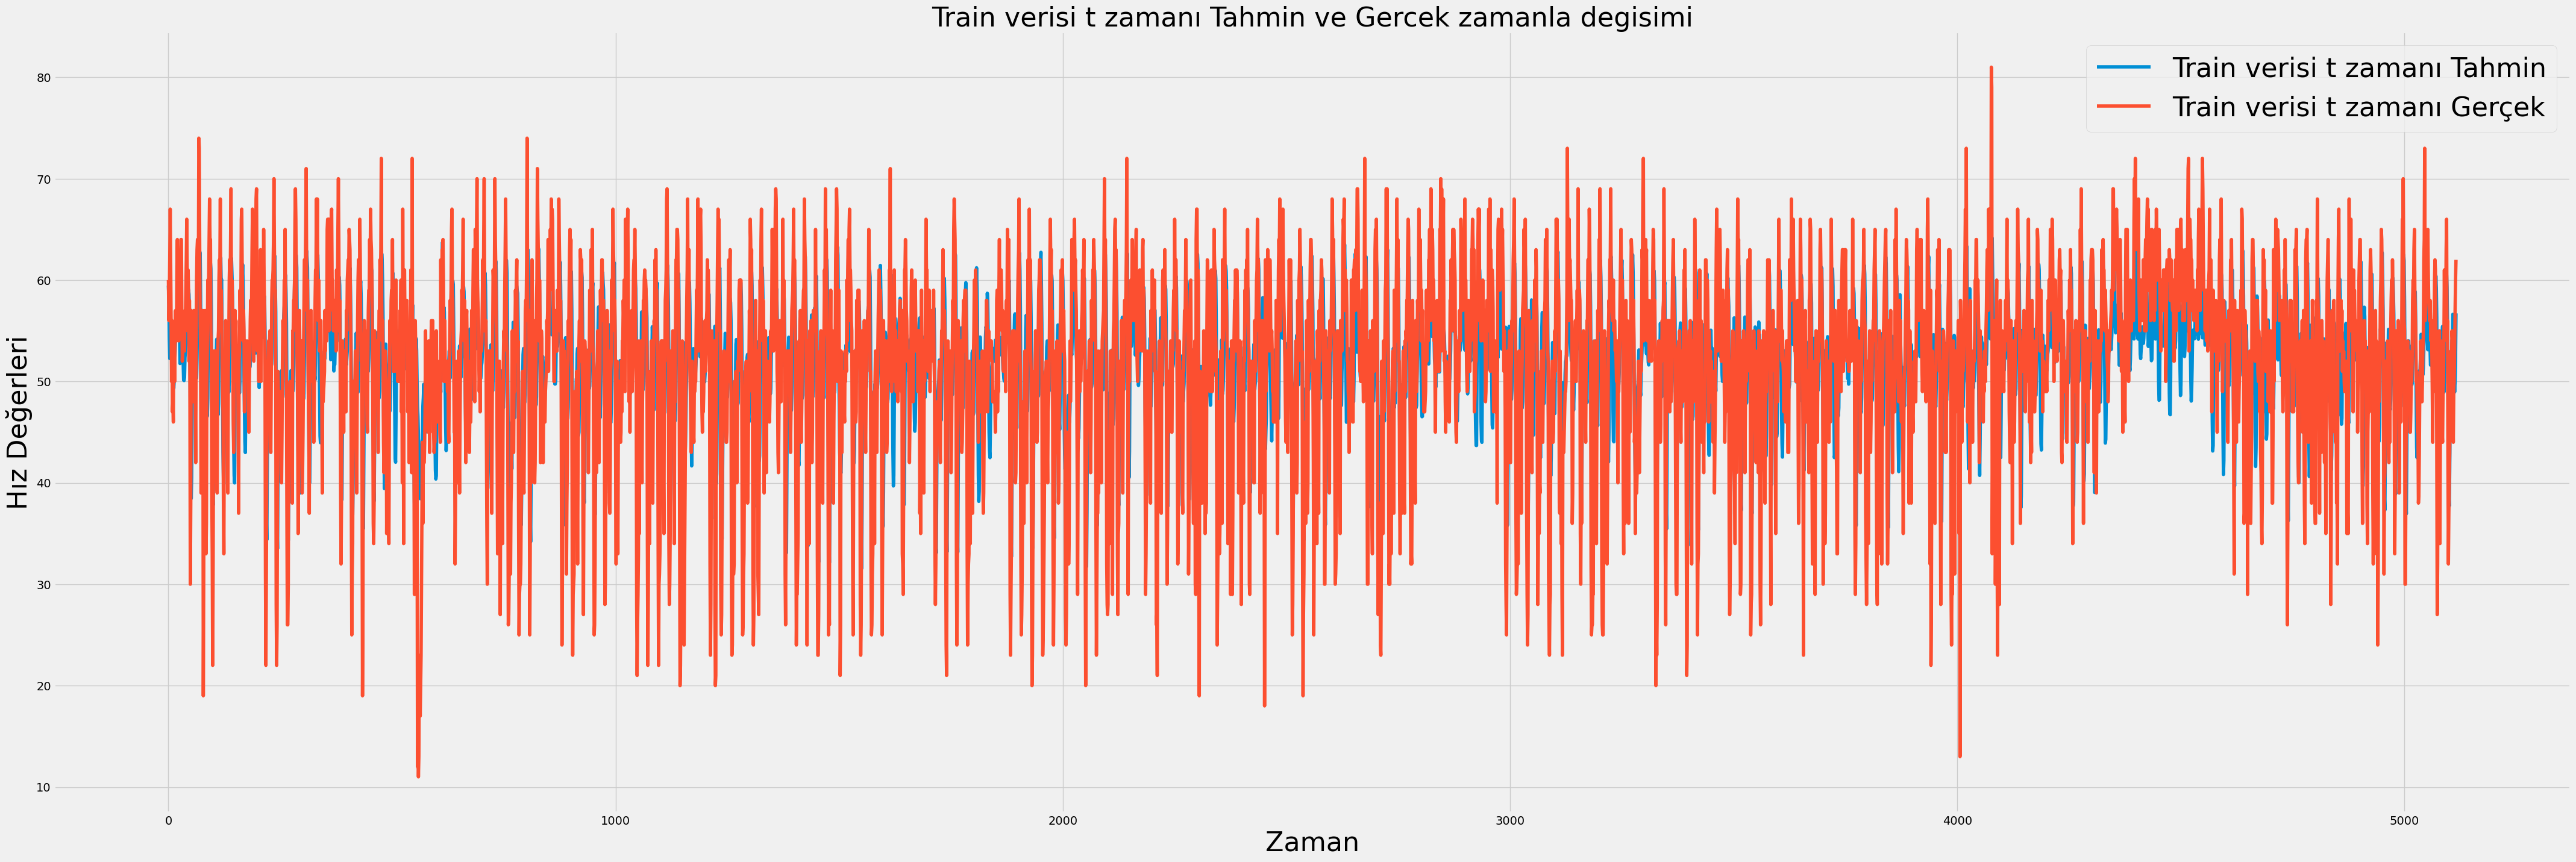

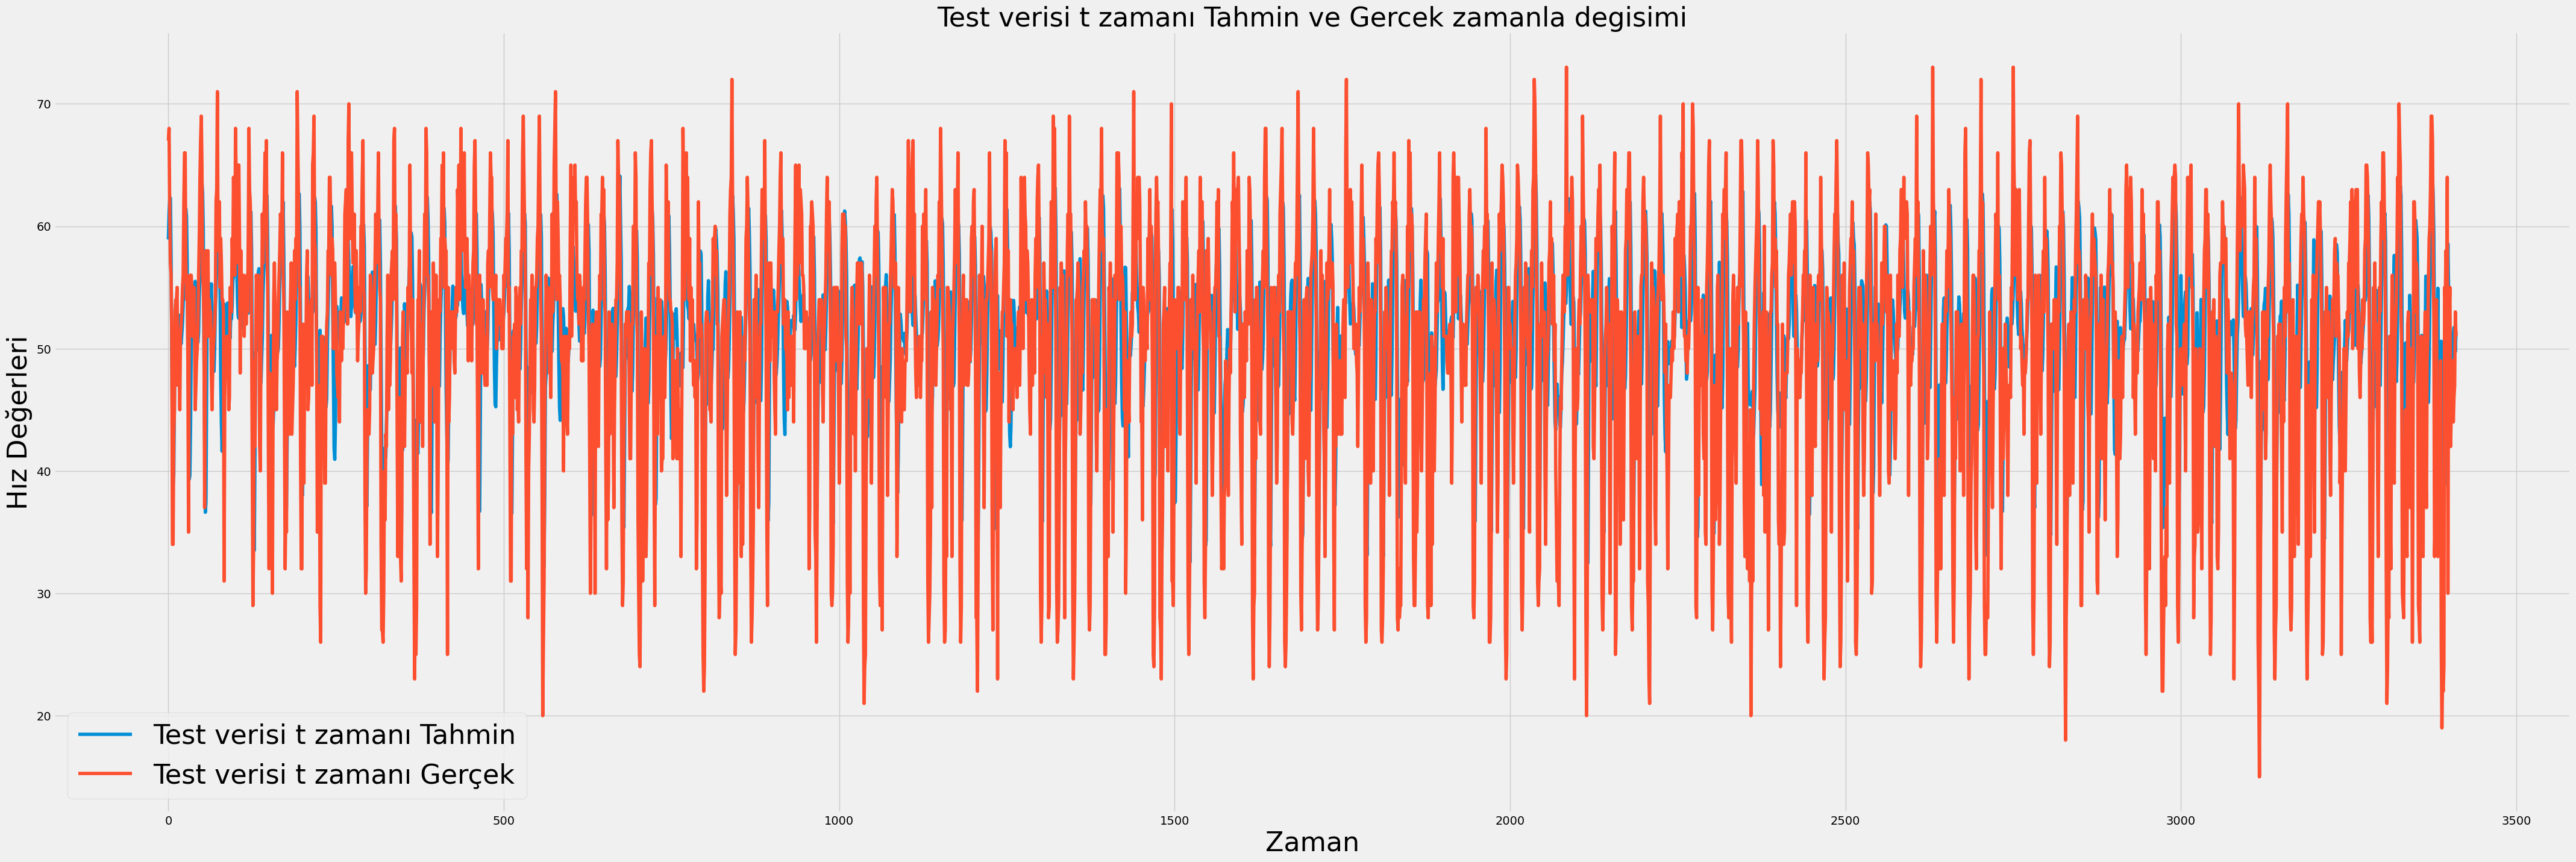

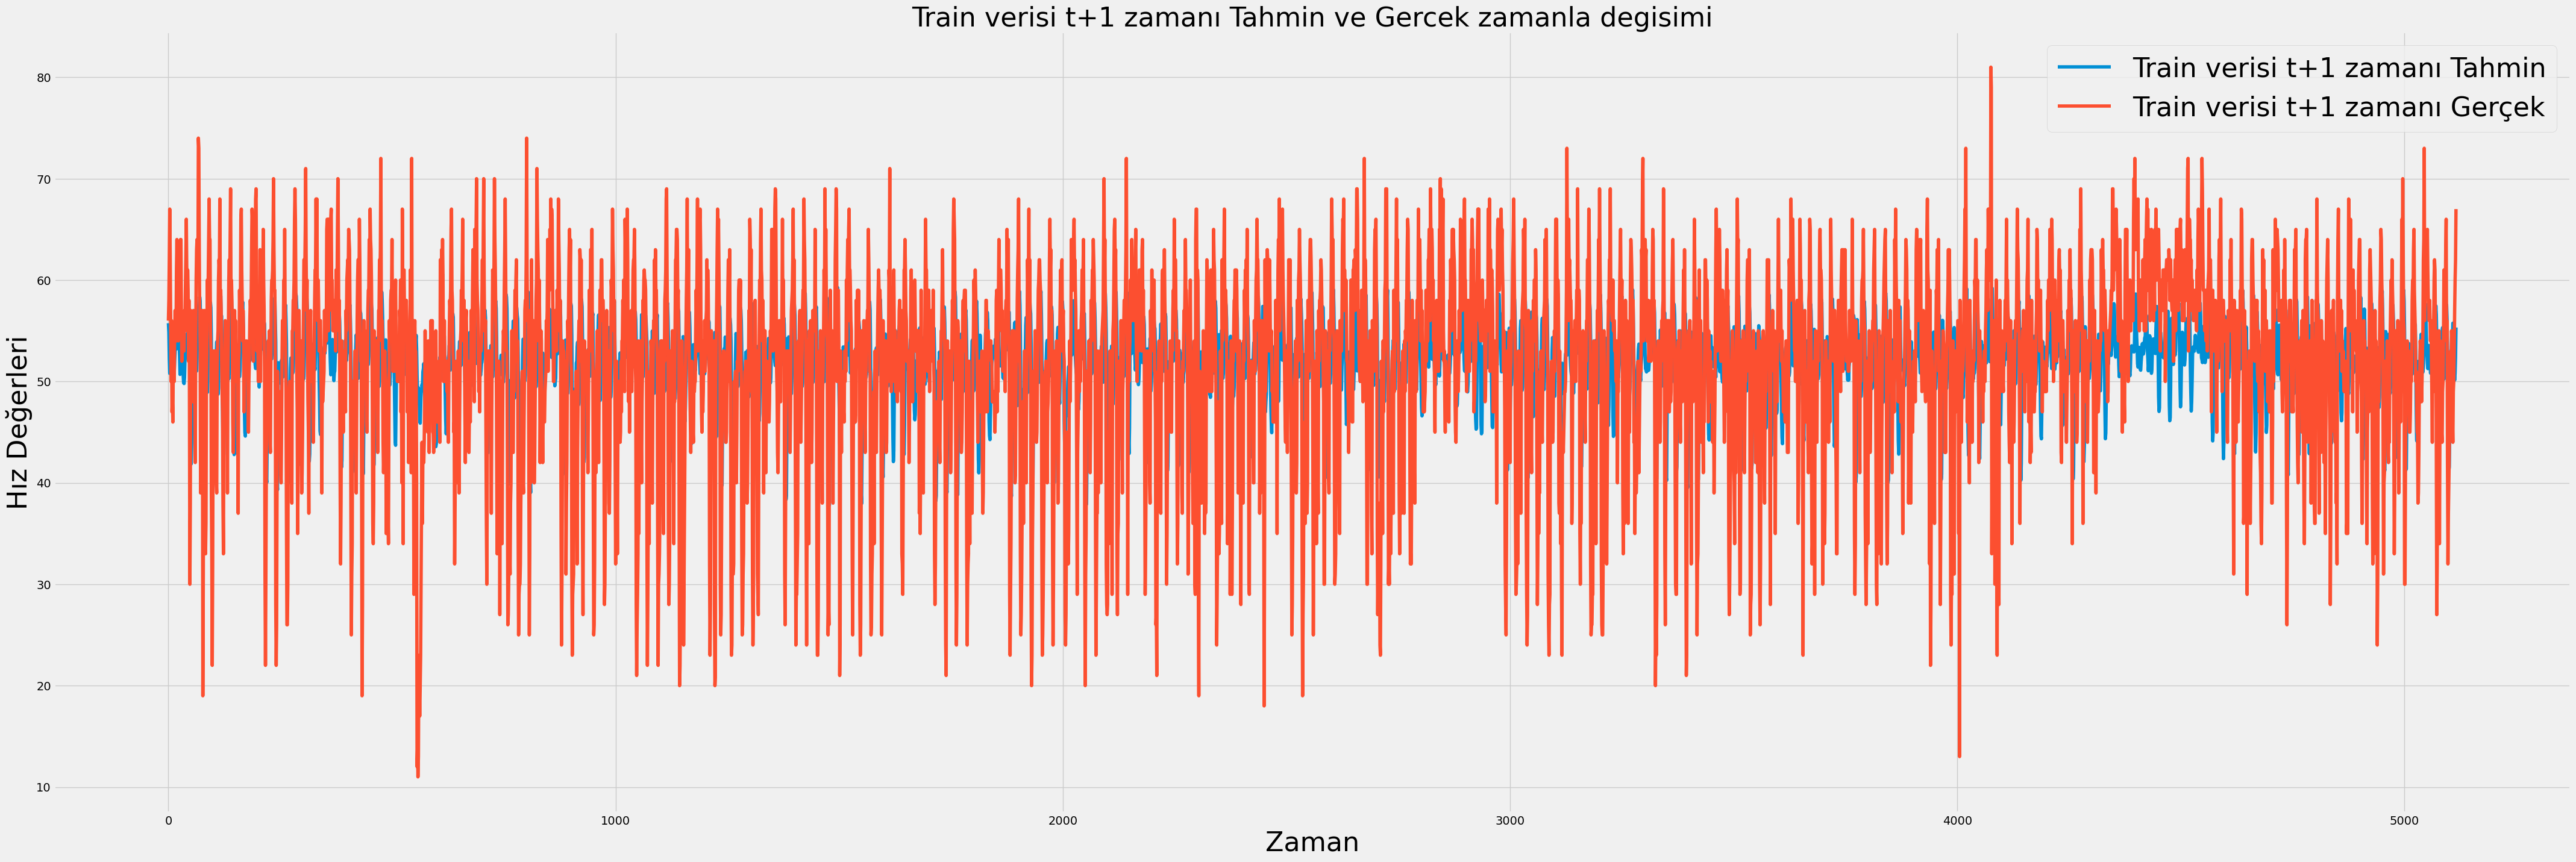

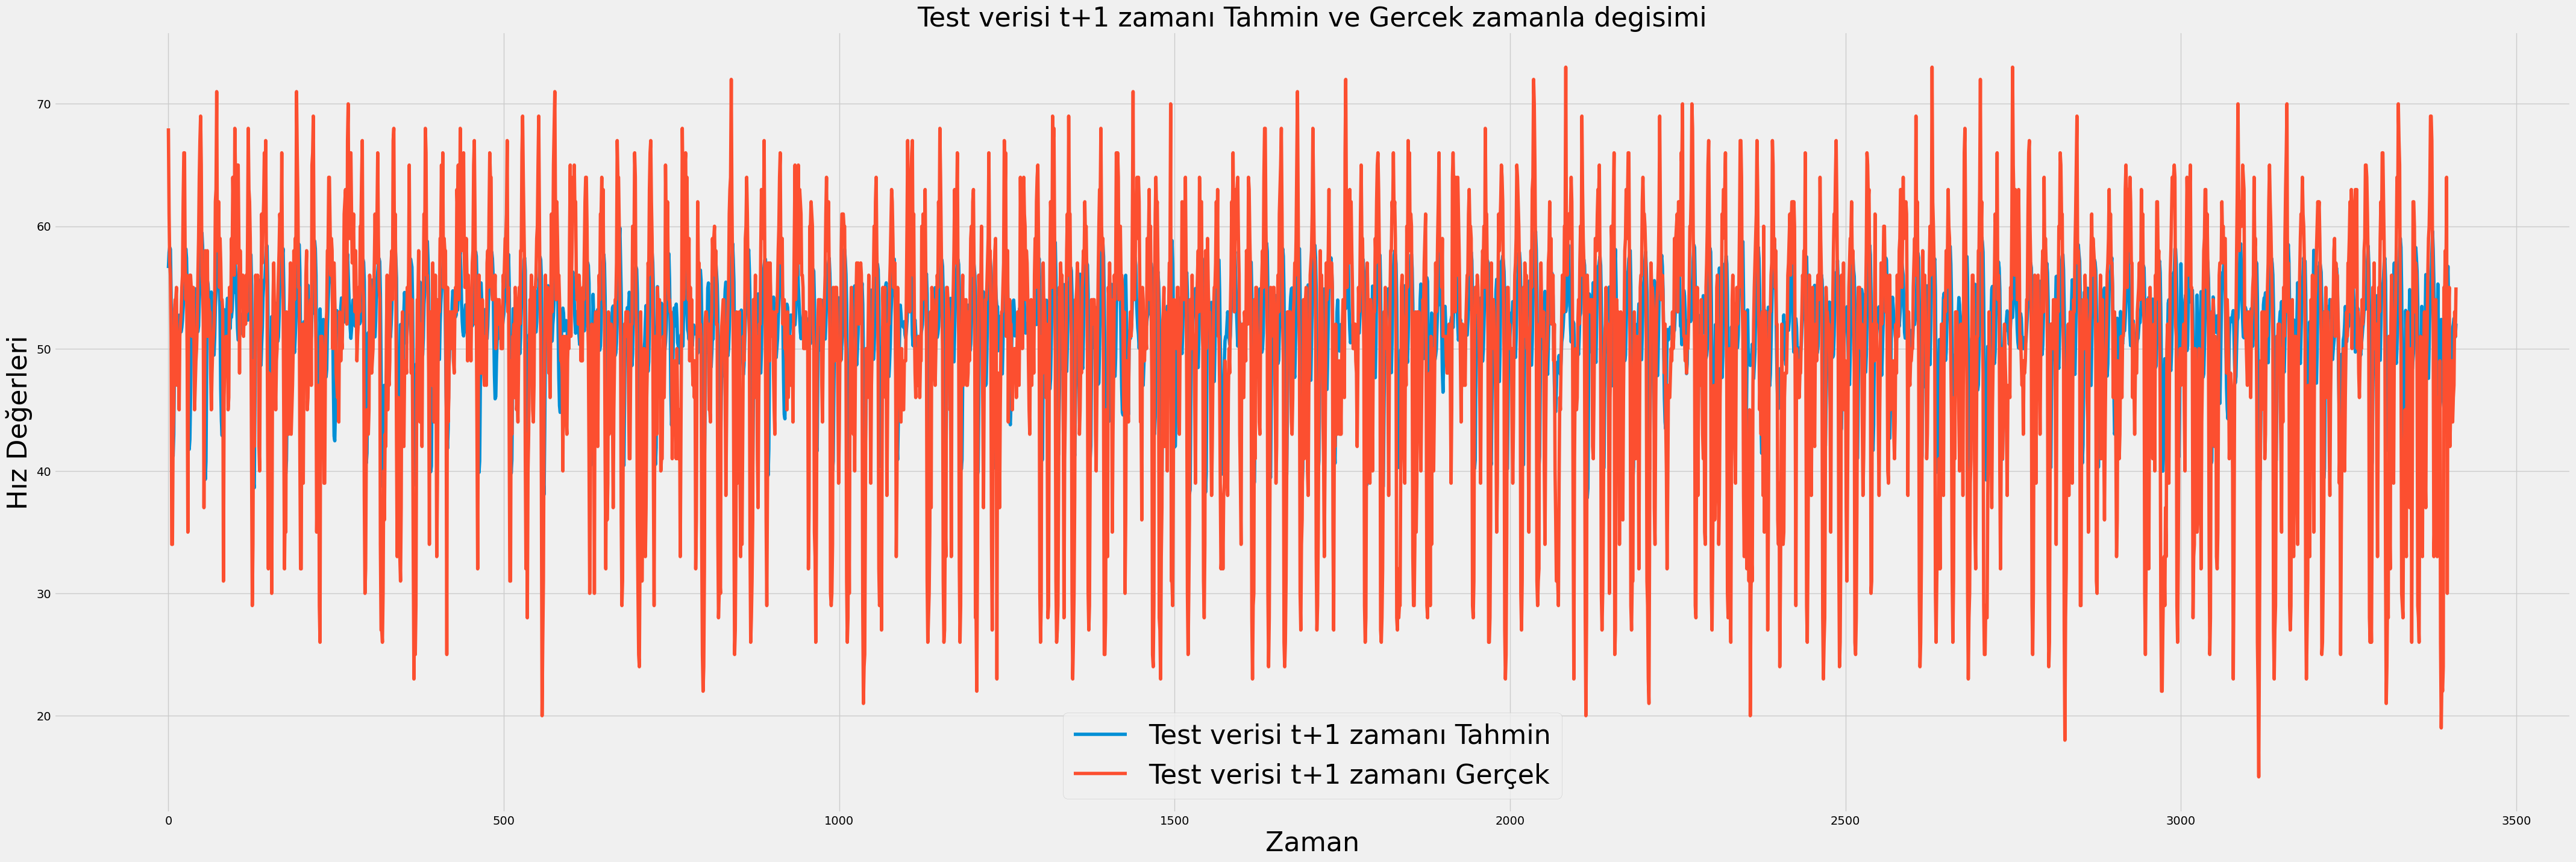

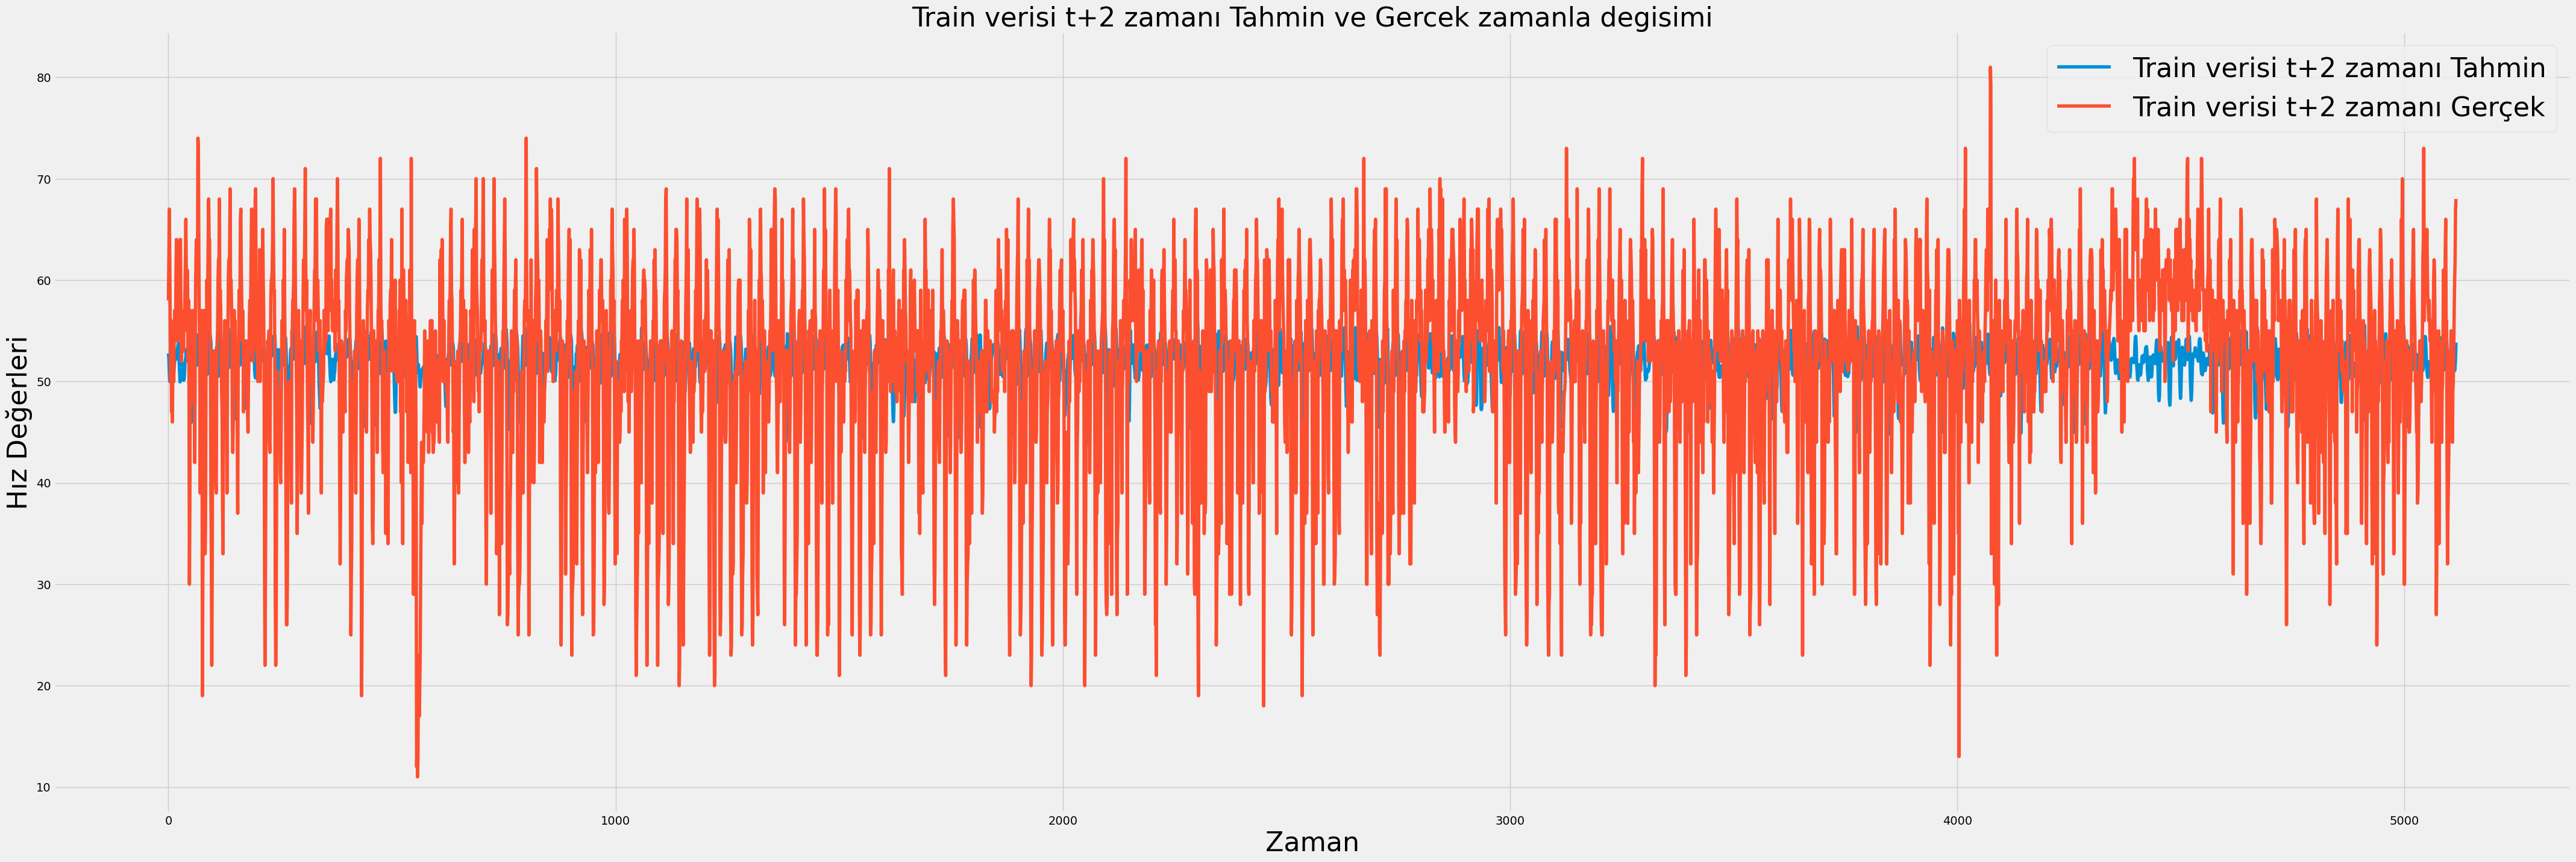

In [18]:
# 10. Test Veri Seti icin Ag sonucu ve verili cikislari cizdiriyoruz

train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')